# Homework 02
## Submission Instructions:
1. Once the notebook is completed, **RESTART THE KERNEL AND RUN ALL CELLS**, save it and submit it. 
2. DO NOT submit the data from the assignment.
3. Whenever we ask to .head(10) the results or print out a value, please use `print()` so for example `print(df.head(10))`. Print only the answers to the questions that have been asked.  Do not print the head of a dataset unless explicitly asked. 
4. Whenever displaying a graph use `plt.show()`
5. For theoretical answers/short answers, use print() (e.g., print("your answer")).
6. Wherever we have code displayed to print out values, use that code as a template to print out your output.  For example, if we give you `print(f'Threshold for best accuracy: {}')` please use code in this style to print out your output.

In [2]:
import pandas as pd
import numpy as np
import time
import dill
import nltk
import json
from pathlib import Path
import re
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import seaborn as sns
import matplotlib.pyplot as plt

# Ensure nltk stopwords and wordnet are downloaded if not already:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [64]:
from sklearn.metrics import classification_report, confusion_matrix

1. Use the same code you wrote for the previous homework assignment, prep your data the same way.  As a reminder:

In the homework data data.zip, there are 2 folders:

- search_results: This contains a folder for each search I did.  The folder is named f'search-{query}_location-{location}'.  Each file in those folders contains a page of the search results.  Most of these searches returned 1000+ results and so they should have 50 pages.
- jobs: This contains all the job postings.  The name of each file is the jid (job ID) and is (I think) unique.

    a. Read in all the search results and extract the `form_search`, `form_location` and `page_number` as well as all the `rawCanonicalZipJobPageUrls` for each job

    b. Create a function, **using a regex**, to return the jid from each of the `rawCanonicalZipJobPageUrls`

    c. Create a data frame from the search results you extracted above and extract the jid using your function above.  Display the `.head()` of the data frame.  Use the column names as below

    d. Create a new table by jid.  Select only the search queries and the jid and then groupby the jid and aggregate the search terms into a list.  `.head()` the results

    e. Load your job assignments.  The job assignments are in job_assignments_sampled.json.  Your files are under your email.

    f. Loop through these job files and get the job description, company description and salary 

    g. Create a pandas data frame from the results

    h. Merge your job data with your search data frame from c

My resulting data frame looks like this:

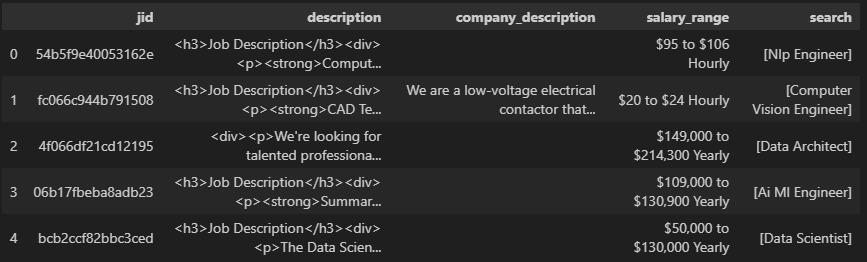

In [3]:

base_path = Path("data/search_results")
rows = []

pat_dir  = re.compile(r"^search-(?P<query>.+)_location-(?P<location>.+)$")
pat_page = re.compile(r"^page_(?P<page_num>\d+)$")

for directory in base_path.iterdir():
    if not directory.is_dir():
        continue 

    m = pat_dir.match(directory.name)
    if not m:  
        continue 

    form_search   = m.group("query")
    form_location = m.group("location")

    for file_path in directory.iterdir():
        if not file_path.is_file() or file_path.suffix.lower() != ".json":
            continue  

        pm = pat_page.match(file_path.stem)
        if not pm:
            continue 

        page_number = int(pm.group("page_num"))

        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        job_cards = data.get("hydrateJobCardsResponse", {}).get("jobCards", [])
        for card in job_cards:
            url = card.get("rawCanonicalZipJobPageUrl")
            if url: 
                rows.append({
                    "search": form_search,
                    "location": form_location,
                    "page_number": page_number,
                    "job_link": url
                })

df = pd.DataFrame(rows)
df['jid'] = df['job_link'].str.extract(r'jid=(.*)')

In [14]:
table=df[['jid','search']].groupby('jid')
search_terms_aggregate=table['search'].agg(list)


with open("job_assignments_sampled.json", "r", encoding="utf-8") as l:
    job_assignments_sampled_file = json.load(l)

jobs = job_assignments_sampled_file.get("mudzimtb@clarkson.edu", {}).get("jobs", [])

if jobs:
    print("True")
else:
    print("False (no jobs found)")



job_list=[]
for job in jobs:
    with open(f"data/jobs/{job}", "r", encoding="utf-8") as m:
        each_job = json.load(m)
        job_description = each_job.get("jobDetails", {}).get("Description", {})
        company_description=each_job.get("companyWidgetProp",{}).get("Description",{}).get("CompanyDescription",{})
        salary=each_job.get("jobDetails",{}).get("Salary",{})
    job_list_dictionary={"job_description": job_description,"company_description": company_description,"salary": salary,"jid":job.rstrip(".json")}
    job_list.append(job_list_dictionary)

job_list_df=pd.DataFrame(job_list)



job_list_df['desc_length'] = job_list_df['job_description'].astype(str).str.len()
job_list_df = job_list_df.sort_values(by='desc_length', ascending=False)


merged=pd.merge(job_list_df,search_terms_aggregate,on="jid", how="left")


True


In [16]:
merged.head(5)


,job_description,company_description,salary,jid,desc_length,search
0,"<p><b>Work Location:</b></p>Mount Laurel, New ...",,"$68,640 to $112,320 Yearly",65b91ccbba4447c7,15000,"[Business_Analyst, Business_Analyst]"
1,"<p>DUTIES ANNUAL SALARY: $121,813 to $178,085 ...",,"$121,813 to $178,085 Yearly",1ca8b1c8c73522b8,15000,"[Data_Architect, Data_Architect]"
2,<div><div><p><b>Title:</b> Managing Consultan...,,$72 to $93 Hourly,cbcca19ab70f64f8,15000,[Data_Architect]
3,"<p>Company Overview With 80,000 customers acro...",,"$247,000 Yearly",4573a7a57e1cabd9,15000,[ai_ml_engineer]
4,<div> <div> Job Details </div> <div> <div> ...,,"$90,000 to $95,000 Yearly",00ba1033c6623680,15000,[Computer_Vision_Engineer]


2. Save this data frame as a json data file using `.to_json`.  Use `orient='records'`. Read this back in using `pd.read_json`and `head()` the results

In [21]:
merged.to_json('data.json',orient='records')
df=pd.read_json('data.json')

In [23]:
df.head(10)

,job_description,company_description,salary,jid,desc_length,search
0,"<p><b>Work Location:</b></p>Mount Laurel, New ...",,"$68,640 to $112,320 Yearly",65b91ccbba4447c7,15000,"[Business_Analyst, Business_Analyst]"
1,"<p>DUTIES ANNUAL SALARY: $121,813 to $178,085 ...",,"$121,813 to $178,085 Yearly",1ca8b1c8c73522b8,15000,"[Data_Architect, Data_Architect]"
2,<div><div><p><b>Title:</b> Managing Consultan...,,$72 to $93 Hourly,cbcca19ab70f64f8,15000,[Data_Architect]
3,"<p>Company Overview With 80,000 customers acro...",,"$247,000 Yearly",4573a7a57e1cabd9,15000,[ai_ml_engineer]
4,<div> <div> Job Details </div> <div> <div> ...,,"$90,000 to $95,000 Yearly",00ba1033c6623680,15000,[Computer_Vision_Engineer]
5,"<div><div class=""ps<i>box-group psc</i>layout ...",Georgia Tech is a top-ranked public research u...,"$103,400 to $166,400 Yearly",814f1f69b13bf822,15000,[nlp_engineer]
6,"<div><strong>Salary:</strong> $86,912.00 - $11...",{},"$86,912 to $119,619 Yearly",3016052330097d56,15000,"[Business_Analyst, Business_Analyst]"
7,<p>Position/Program Information EXAM NUMBER: P...,,"$113,103 to $152,410 Yearly",bfdadab9795f70c7,15000,None
8,<strong> </strong><strong>POSITION SUMMARY</st...,,$36 to $61 Hourly,5b5b541a2f640f89,15000,[Business_Analyst]
9,<div><b> Job Details </b><br><br><strong>Worki...,"The Minnesota State Demographic Center (SDC), ...",$42 to $72 Hourly,2593d8bcd438a842,15000,[Data_Architect]


3. Filter out all jobs where there was no matching search result.  Also, only include the jobs where there was only 1 label.

In [24]:
df_nun= df[df["search"].notna()]
df1 = df_nun[df_nun["search"].str.len() == 1].copy()
df1["search"] = df1["search"].str[0]
df1.head(10)

,job_description,company_description,salary,jid,desc_length,search
2,<div><div><p><b>Title:</b> Managing Consultan...,,$72 to $93 Hourly,cbcca19ab70f64f8,15000,Data_Architect
3,"<p>Company Overview With 80,000 customers acro...",,"$247,000 Yearly",4573a7a57e1cabd9,15000,ai_ml_engineer
4,<div> <div> Job Details </div> <div> <div> ...,,"$90,000 to $95,000 Yearly",00ba1033c6623680,15000,Computer_Vision_Engineer
5,"<div><div class=""ps<i>box-group psc</i>layout ...",Georgia Tech is a top-ranked public research u...,"$103,400 to $166,400 Yearly",814f1f69b13bf822,15000,nlp_engineer
8,<strong> </strong><strong>POSITION SUMMARY</st...,,$36 to $61 Hourly,5b5b541a2f640f89,15000,Business_Analyst
9,<div><b> Job Details </b><br><br><strong>Worki...,"The Minnesota State Demographic Center (SDC), ...",$42 to $72 Hourly,2593d8bcd438a842,15000,Data_Architect
10,Job Description:\n\nAbout the Northwest Portla...,,"$123,000 to $141,000 Yearly",29350fc162ece93c,15000,Data_Engineer
11,<div> Quality Tech - Level 2 <div class...,,$16 to $22 Hourly,9717e29d2671dba3,15000,Computer_Vision_Engineer
12,<div> <div> <p></p> Company Description ...,ProSidian is a management and operations consu...,$35 to $58 Hourly,704f68815cb68006,15000,Business_Analyst
13,<p>Major Duties and Responsibilities The Data ...,,"$66,811 Yearly",ae58cf6e092c8c8e,14951,Data_Analyst


4. Extract the text of the job description from your job's description, which is in html.  The easiest way to get that is to use `BeautifulSoup(x).get_text(' \n')` where x is the text (you could do this with the pandas `.apply` function and a `lambda` function).  You may need to install the BeautifulSoup package.  Print out one of the texts

In [27]:
df1.loc[:, 'job_description_text'] = df1['job_description'].apply(lambda job_description: BeautifulSoup(job_description).get_text())
print(df1["job_description_text"].iloc[0])

Title:  Managing Consultant - Data Architecture Level:   P3 - AdvisoryFLSA Status:  (People and Culture will complete)  Travel:  Up to 25%Job OverviewAs a Managing Consultant, Data Architecture at Tegria, you will play a key role in delivering tailored data solutions to our clients, ensuring the optimal use of their data to drive business success. You will work closely with clients to understand their needs, assess requirements, and design scalable, efficient data architectures. Your responsibilities will include selecting the appropriate technologies, guiding the implementation process, and overseeing the successful delivery of projects.In this role, you will lead project planning, collaborate with cross-functional teams, and ensure that all solutions align with the client's goals and objectives. You will be instrumental in helping organizations unlock the full potential of their data, fostering greater business intelligence and operational efficiency.Core ResponsibilitiesClient Engag

In [31]:
df1.loc[:, 'job_description_text'] = df1['job_description'].apply(lambda job_description: BeautifulSoup(job_description).get_text('\n'))
print(df1["job_description_text"].iloc[0])

Title:
  Managing Consultant - Data Architecture 
Level: 
  P3 - Advisory
FLSA Status: 
 (People and Culture will complete)  
Travel:
  Up to 25%
Job Overview
As a Managing Consultant, Data Architecture at Tegria, you will play a key role in delivering tailored data solutions to our clients, ensuring the optimal use of their data to drive business success. You will work closely with clients to understand their needs, assess requirements, and design scalable, efficient data architectures. Your responsibilities will include selecting the appropriate technologies, guiding the implementation process, and overseeing the successful delivery of projects.
In this role, you will lead project planning, collaborate with cross-functional teams, and ensure that all solutions align with the client's goals and objectives. You will be instrumental in helping organizations unlock the full potential of their data, fostering greater business intelligence and operational efficiency.
Core Responsibilities


5. Display the unique labels

In [32]:
unique_labels = df1["search"].unique()
print(unique_labels)

['Data_Architect' 'ai_ml_engineer' 'Computer_Vision_Engineer'
 'nlp_engineer' 'Business_Analyst' 'Data_Engineer' 'Data_Analyst'
 'Machine_Learning_Engineer' 'Data_Scientist' 'MLOps_Engineer']


6. Create a count plot displaying the distribution of your labels.

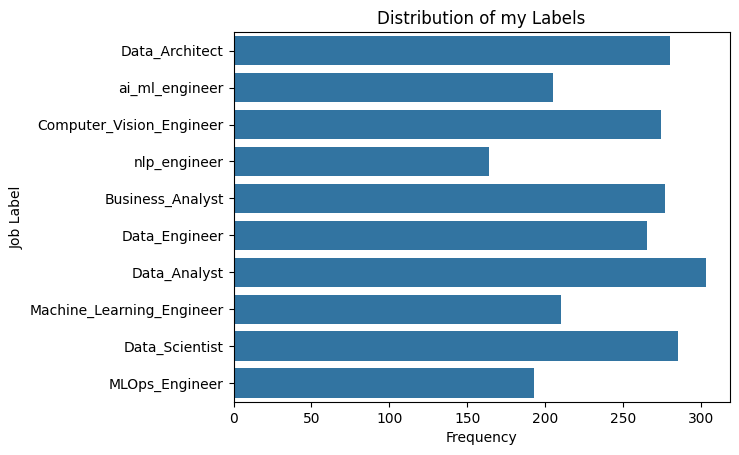

In [34]:
exploded_labels = df1['search']
sns.countplot(y=exploded_labels)
plt.title('Distribution of my Labels')
plt.xlabel('Frequency')
plt.ylabel('Job Label')
plt.show()


7. Are your labels evenly distributed?

In [37]:
print('The range of frequencies goes from 160 which is the lowest to 300 which is the highest that’s almost twice difference in representation.\n So labels are not evenly distributed ')

The range of frequencies goes from 160 which is the lowest to 300 which is the highest that’s almost twice difference in representation.
 So labels are not evenly distributed 


8. Create a train test split using the dataframe. Use a test size of 0.2, random state of 37 and stratify the split on y to even split the target variable.

In [ ]:
X = df1["job_description_text"]
Y= df1["search"]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=37,stratify=Y)




9. Vectorize the data using a CountVectorizer with max_features=5000

In [ ]:
vectorizer = CountVectorizer(max_features=5000)

X_traincv = vectorizer.fit_transform(X_train)
X_testcv = vectorizer.transform(X_test)


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of Y_train: {Y_train.shape}")

Shape of X_train: (1964,)
Shape of Y_train: (1964,)


10. Fit a LogisticRegression on the vectorized data. Print out the accuracy, recall, precision, F1 score of the fitted model. Use `average='macro'`.  These will be your baseline metrics.

In [ ]:
clf = LogisticRegression(max_iter=1000, random_state=37)
clf.fit(X_traincv, Y_train)
Y_pred = clf.predict(X_testcv)

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred))
print("Precision:", metrics.precision_score(Y_test, Y_pred, average='macro'))
print("Recall:", metrics.recall_score(Y_test, Y_pred, average='macro'))
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average='macro'))


Accuracy: 0.7439024390243902
Precision: 0.7237336992335555
Recall: 0.7188261128433847
F1 Score: 0.7198739281936516


In [61]:
print("\nClassification Report:\n")
print(classification_report(Y_test, Y_pred))




Classification Report:

                           precision    recall  f1-score   support

         Business_Analyst       0.91      0.89      0.90        55
 Computer_Vision_Engineer       0.73      0.78      0.75        55
             Data_Analyst       0.83      0.89      0.86        61
           Data_Architect       0.80      0.88      0.84        56
            Data_Engineer       0.77      0.70      0.73        53
           Data_Scientist       0.80      0.84      0.82        57
           MLOps_Engineer       0.57      0.51      0.54        39
Machine_Learning_Engineer       0.60      0.57      0.59        42
           ai_ml_engineer       0.56      0.59      0.57        41
             nlp_engineer       0.67      0.55      0.60        33

                 accuracy                           0.74       492
                macro avg       0.72      0.72      0.72       492
             weighted avg       0.74      0.74      0.74       492



11. Display a confusion matrix normalized by the rows and with values formatted as percents

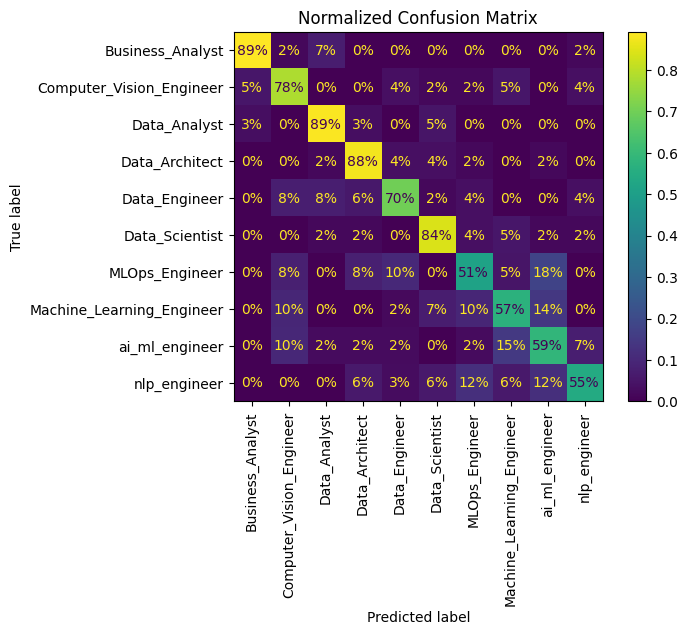

In [66]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred,
    normalize="true", values_format=".0%")

plt.xticks(rotation=90)  
plt.title("Normalized Confusion Matrix")
plt.show()



12. Which categories does it perform best on?  The worst?

In [68]:
print("Best for categories like Business_Analyst, Data_Analyst, Data_Architect, Data_Scientist\n"
      "Worst for MLOps_Engineer, ai_ml_engineer, Machine_Learning_Engineer, nlp_engineer")


Best for categories like Business_Analyst, Data_Analyst, Data_Architect, Data_Scientist
Worst for MLOps_Engineer, ai_ml_engineer, Machine_Learning_Engineer, nlp_engineer


13. In the next steps of this homework.

- You will fit 16 different scenarios for all the combinations using the below parameters.
    - `lemmatization = ['lemmatize', 'not_lemmatize']`
    - `stop_words = ['remove_stop_words', 'not_remove_stop_words']`
    - `n_grams = [1,2]`
    - `binarization = [True, False]`

 - So, first to complete these scenarios function definition for `clean_texts` is provided below that:
    - Lowercase the text
    - Tokenize using a simple pattern
    - lemmatizing tokens
    - remove stopwords
    - returns a list of cleaned strings

In [ ]:
def clean_texts(texts, lemmatize=False, remove_stopwords=False):
    lemmatizer = WordNetLemmatizer()
    eng_stopwords = set(stopwords.words('english'))
    clean_docs = []
    token_pattern = r'(\b[\w]{2,}\b)'

    for doc in texts:
        
        doc = doc.lower()
        
        tokens = nltk.regexp_tokenize(doc, token_pattern)
        
        if lemmatize:
            tokens = [lemmatizer.lemmatize(t) for t in tokens]
        
        if remove_stopwords:
            tokens = [t for t in tokens if t not in eng_stopwords]
        
        cleaned = ' '.join(tokens)
        clean_docs.append(cleaned)

    return clean_docs





## Hints:

- What I did, in my solutions, was to prep my text first by lemmatizing and removing stop words.  Since you also have scenarios where don't do these things, you have 4 ways you can prepare your text.  

    - Lemmatized and stop words removed
    - Lemmatized and stop words not removed
    - Not Lemmatized and stop words removed
    - Not Lemmatized and stop words not removed

- If you prepared your text each time you run a scenario (all 16 times), then you will be fitting models for a ***lonnnnnnnnnnnnnnnnnngggggggggggggggggggg*** time.

14. Create a function called `evaluate_scenario` using above scenarios.
- The `CountVectorizer` has a very convenient bigram argument which will create the bigrams for you
- Build a pipeline having `CountVectorizer` and `LogisticRegression`
- Use `max_features=5000` in the `CountVectorizer`.
- Use `max_iter=1000` for `LogisticRegression`
- Perform cross validation with `cv=10` using an `f1_macro` scoring strategy on the training data and store the scores to create a boxplot later.
- Fit a model on all the training data as well and test it on the test set
- The function returns a dictionary consisting of all the f1-scores just as provided below
    - mean_f1_cv_score: the average f1 score of the 10 folds for each scenario
    - median_f1_cv_score: the median f1 score of the 10 fold for each scenario
    - std_f1_cv_score: the standard deviation score of the 10 fold for each scenario
    - total_fit_time: total fit time for each scenario
    - test_f1_score: the test f1 score for the data on the held out test set

In [ ]:
def evaluate_scenario(
    X_train, Y_train, X_test, Y_test,
    lemmatize=False, remove_stopwords=False,
    n_grams=1, binarize=False,
    max_features=5000, max_iter=1000, cv=10
):

    X_train_clean = clean_texts(X_train, lemmatize=lemmatize, remove_stopwords=remove_stopwords)
    X_test_clean  = clean_texts(X_test,  lemmatize=lemmatize, remove_stopwords=remove_stopwords)

    pipe = Pipeline([
        ("vect", CountVectorizer(
            max_features=max_features,
            ngram_range=(1, n_grams),   
            binary=binarize
        )),
        ("clf", LogisticRegression(max_iter=max_iter, random_state=37))
    ])


    cv_res = cross_validate(
        pipe, X_train_clean, Y_train,
        scoring="f1_macro",
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )
    cv_scores = cv_res["test_score"]
    mean_f1_cv = float(np.mean(cv_scores))
    median_f1_cv = float(np.median(cv_scores))
    std_f1_cv = float(np.std(cv_scores, ddof=1)) if cv > 1 else 0.0
    total_fit_time = float(np.sum(cv_res["fit_time"]))


    pipe.fit(X_train_clean, Y_train)
    Y_pred = pipe.predict(X_test_clean)
    test_f1 = float(metrics.f1_score(Y_test, Y_pred, average="macro"))

    return {
        "lemmatize": lemmatize,
        "remove_stopwords": remove_stopwords,
        "n_grams": n_grams,
        "binary": binarize,
        "mean_f1_cv_score": mean_f1_cv,
        "median_f1_cv_score": median_f1_cv,
        "std_f1_cv_score": std_f1_cv,
        "total_fit_time": total_fit_time,
        "test_f1_score": test_f1,
        "cv_f1_scores": cv_scores,
        "model": pipe
    }

scenarios = []
cv_scores_map = {}

for lemmatize in [True, False]:
    for remove_stopwords in [True, False]:
        for n_grams in [1, 2]:
            for binarize in [True, False]:
                res = evaluate_scenario(
                    X_train, Y_train, X_test, Y_test,
                    lemmatize=lemmatize,
                    remove_stopwords=remove_stopwords,
                    n_grams=n_grams,
                    binarize=binarize
                )
                scenarios.append({k: v for k, v in res.items() if k not in ("cv_f1_scores", "model")})
                key = (lemmatize, remove_stopwords, n_grams, binarize)
                cv_scores_map[key] = res["cv_f1_scores"]

results_df = pd.DataFrame(scenarios).sort_values("test_f1_score", ascending=False).reset_index(drop=True)
print("\nTop scenarios by held-out test_f1_score:")




Top scenarios by held-out test_f1_score:
   lemmatize  remove_stopwords  n_grams  binary  mean_f1_cv_score  \
0       True              True        2   False          0.743676   
1      False              True        2    True          0.742786   
2       True              True        1   False          0.706912   
3      False              True        2   False          0.745259   
4      False             False        2   False          0.732527   
5       True              True        2    True          0.736205   
6      False              True        1   False          0.716002   
7      False             False        2    True          0.736345   
8       True             False        2   False          0.735201   
9      False             False        1   False          0.701536   

   median_f1_cv_score  std_f1_cv_score  total_fit_time  test_f1_score  
0            0.746649         0.026630      126.057821       0.773105  
1            0.753667         0.027991       78.400141

In [73]:
results_df.head()

,lemmatize,remove_stopwords,n_grams,binary,mean_f1_cv_score,median_f1_cv_score,std_f1_cv_score,total_fit_time,test_f1_score
0,True,True,2,False,0.743676,0.746649,0.026630,126.057821,0.773105
1,False,True,2,True,0.742786,0.753667,0.027991,78.400141,0.745364
2,True,True,1,False,0.706912,0.726134,0.037678,90.537479,0.741265
3,False,True,2,False,0.745259,0.743959,0.029475,118.182789,0.737216
4,False,False,2,False,0.732527,0.737394,0.036984,270.108377,0.736619


15. Iterate through each scenario and fit the data from each scenario and evaluate each using the function we created above. Store all the scenarios into a single list.


In [74]:
from itertools import product

all_scenarios = []

for lemmatize, remove_stopwords, n_grams, binarize in product(
    [True, False], [True, False], [1, 2], [True, False]
):
    res = evaluate_scenario(
        X_train, Y_train, X_test, Y_test,
        lemmatize=lemmatize,
        remove_stopwords=remove_stopwords,
        n_grams=n_grams,
        binarize=binarize
    )
    all_scenarios.append(res)



In [ ]:

print(f"Total scenarios stored: {len(all_scenarios)}") 

Total scenarios stored: 16


16. Create a dataframe with the scenario results. Print the head of the dataframe.

In [76]:
results_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ("cv_f1_scores", "model")}
    for r in all_scenarios
])

results_df.head()


,lemmatize,remove_stopwords,n_grams,binary,mean_f1_cv_score,median_f1_cv_score,std_f1_cv_score,total_fit_time,test_f1_score
0,True,True,1,True,0.688409,0.710363,0.043128,26.953677,0.676582
1,True,True,1,False,0.706912,0.726134,0.037678,61.194037,0.741265
2,True,True,2,True,0.736205,0.737278,0.032908,69.432034,0.735835
3,True,True,2,False,0.743676,0.746649,0.026630,108.512162,0.773105
4,True,False,1,True,0.687851,0.690384,0.048302,35.139317,0.654679


17. Prepare a CSV using the dataframe, named `model_card.csv` which will summarize your 16 scenarios. It should have the columns like the provided sample and the following values filled out
    - mean_f1_cv_score: the average f1 score of the 10 folds for each scenario
    - median_f1_cv_score: the median f1 score of the 10 fold for each scenario
    - std_f1_cv_score: the standard deviation score of the 10 fold for each scenario
    - total_fit_time: total fit time for each scenario
    - test_f1_score: the test f1 score

In [81]:

cols = [
    "lemmatize", "remove_stopwords", "n_grams", "binary",
    "mean_f1_cv_score", "median_f1_cv_score", "std_f1_cv_score",
    "total_fit_time", "test_f1_score"
]


model_card = (
    results_df[cols]
    .sort_values("test_f1_score", ascending=False)
    .reset_index(drop=True)
    .round({
        "mean_f1_cv_score": 4,
        "median_f1_cv_score": 4,
        "std_f1_cv_score": 4,
        "total_fit_time": 3,
        "test_f1_score": 4
    })
)

model_card.to_csv("model_card.csv", index=False)




In [82]:
model_card.head()

,lemmatize,remove_stopwords,n_grams,binary,mean_f1_cv_score,median_f1_cv_score,std_f1_cv_score,total_fit_time,test_f1_score
0,True,True,2,False,0.7437,0.7466,0.0266,108.512,0.7731
1,False,True,2,True,0.7428,0.7537,0.0280,74.410,0.7454
2,True,True,1,False,0.7069,0.7261,0.0377,61.194,0.7413
3,False,True,2,False,0.7453,0.7440,0.0295,119.141,0.7372
4,False,False,2,False,0.7325,0.7374,0.0370,274.095,0.7366


18. Create a boxplot with the scenario description on x-axis and f1-score on the y-axis. Add a red dot for the test set f1-score. A sample is given in the homework zip file. You can use it as a reference.

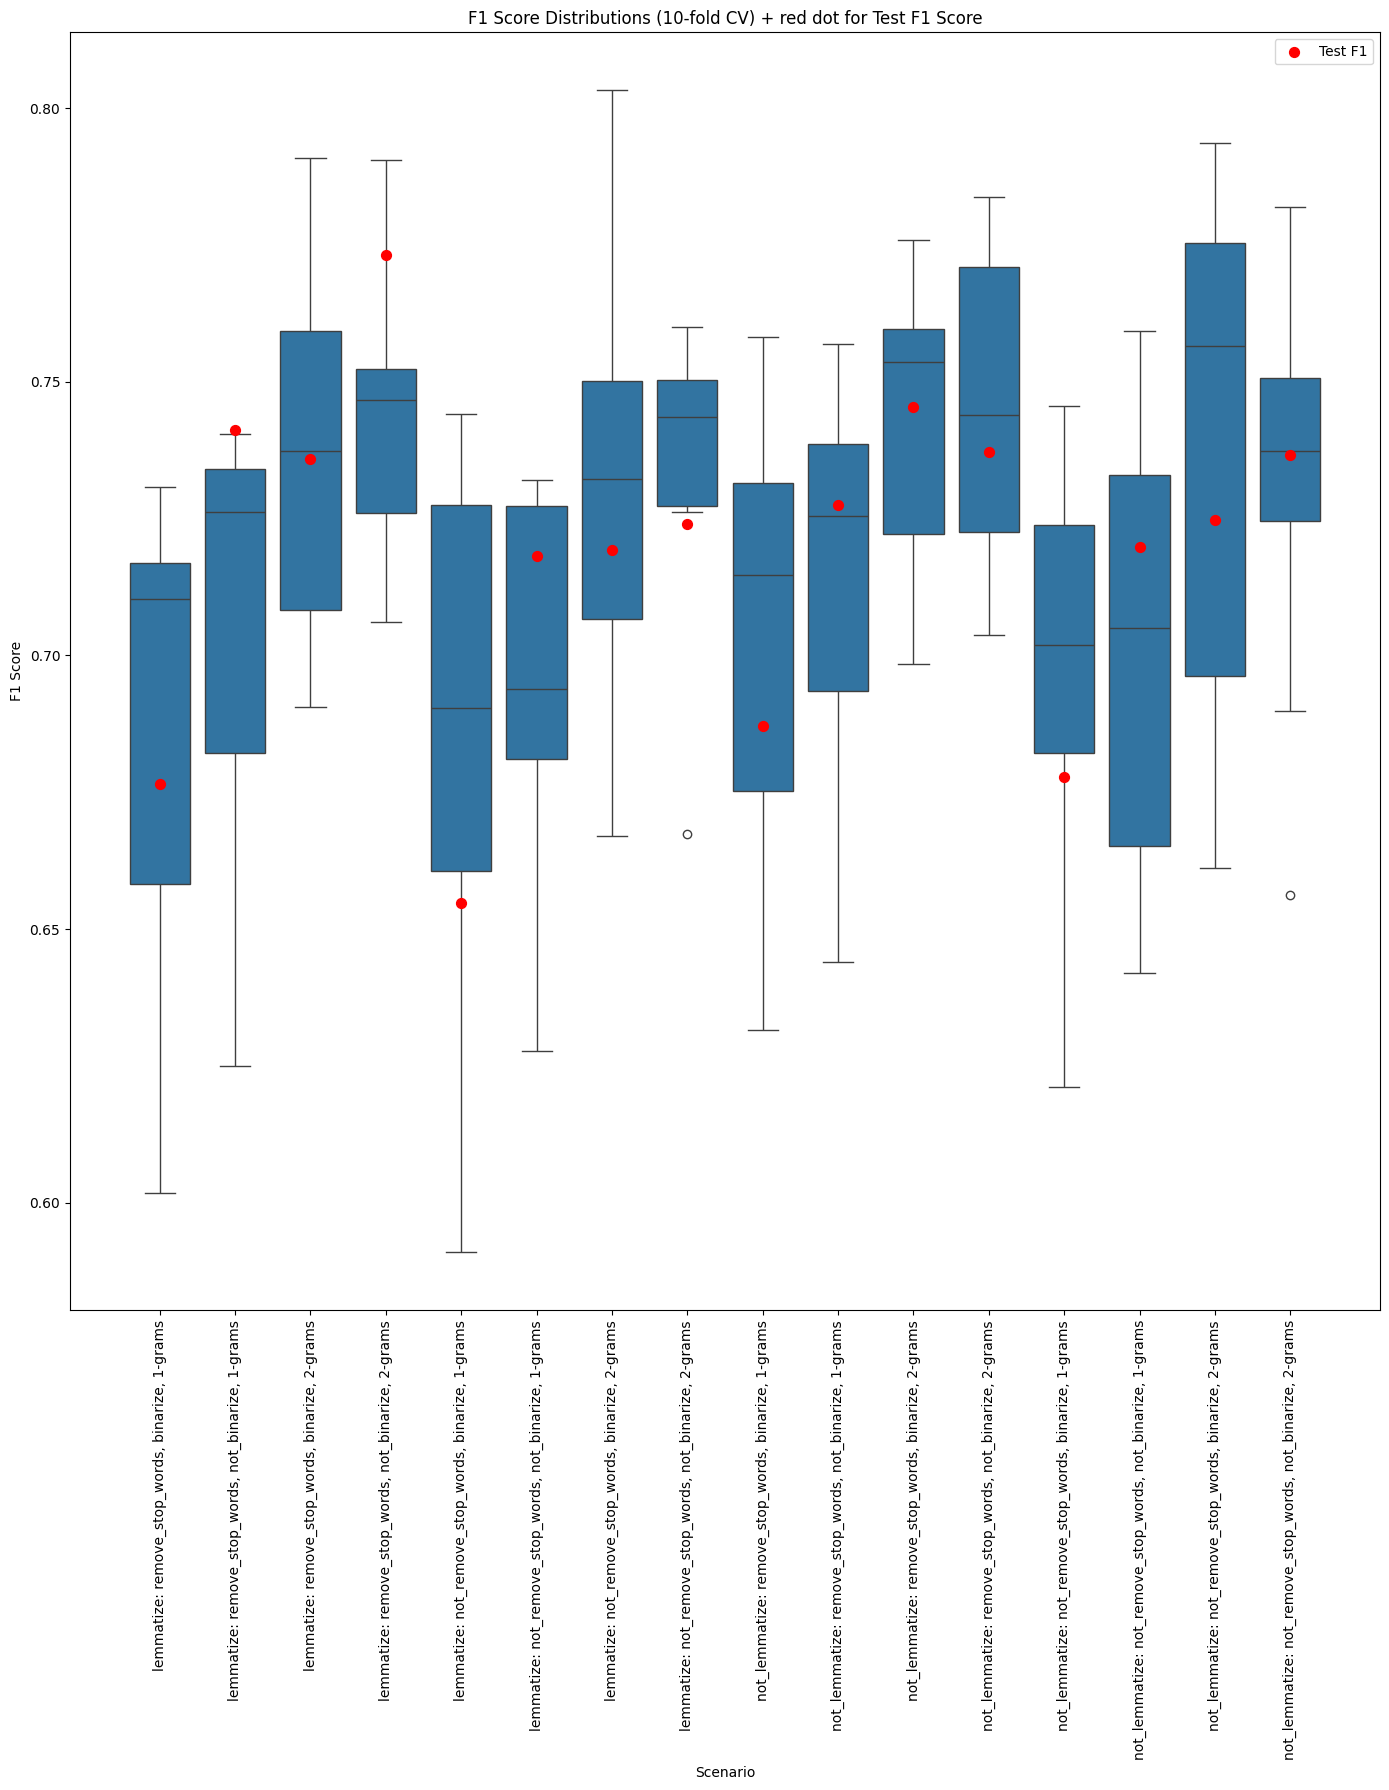

In [ ]:

def scenario_label(r):
    return (f"{'lemmatize' if r['lemmatize'] else 'not_lemmatize'}: "
            f"{'remove_stop_words' if r['remove_stopwords'] else 'not_remove_stop_words'}, "
            f"{'binarize' if r['binary'] else 'not_binarize'}, "
            f"{r['n_grams']}-grams")


order = [scenario_label(r) for r in all_scenarios]

box_df = pd.DataFrame(
    [{"Scenario": scenario_label(r), "F1 Score": s}
     for r in all_scenarios
     for s in r["cv_f1_scores"]]
)

test_pts = pd.DataFrame(
    [{"Scenario": scenario_label(r), "test_f1": r["test_f1_score"]}
     for r in all_scenarios]
)

plt.figure(figsize=(14, 18)) 
ax = sns.boxplot(data=box_df, x="Scenario", y="F1 Score", order=order)
ax.set_title("F1 Score Distributions (10-fold CV) + red dot for Test F1 Score")
ax.set_xlabel("Scenario")
ax.set_ylabel("F1 Score")

xpos = np.arange(len(order))
yvals = [test_pts.loc[test_pts["Scenario"] == sc, "test_f1"].values[0] for sc in order]
ax.scatter(xpos, yvals, color="red", s=50, zorder=4, label="Test F1")

plt.xticks(rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


19. Refit your best model with the parameters from that produced the model with the best test f1 score.  Print out the metrics for that best model on the test set.

In [85]:

best_params = results_df.iloc[0]

lem     = bool(best_params["lemmatize"])
sw      = bool(best_params["remove_stopwords"])
ngr     = int(best_params["n_grams"])
binary  = bool(best_params["binary"])

print("Best scenario:",
      f"lemmatize={lem}, remove_stopwords={sw}, n_grams={ngr}, binary={binary}")

X_train_best = clean_texts(X_train, lemmatize=lem, remove_stopwords=sw)
X_test_best  = clean_texts(X_test,  lemmatize=lem, remove_stopwords=sw)

vec = CountVectorizer(max_features=5000, ngram_range=(1, ngr), binary=binary)
Xtr = vec.fit_transform(X_train_best)
Xte = vec.transform(X_test_best)

clf = LogisticRegression(max_iter=1000, random_state=37)
clf.fit(Xtr, Y_train)
Y_pred = clf.predict(Xte)

acc  = metrics.accuracy_score(Y_test, Y_pred)
prec = metrics.precision_score(Y_test, Y_pred, average="macro", zero_division=0)
rec  = metrics.recall_score(Y_test, Y_pred, average="macro", zero_division=0)
f1   = metrics.f1_score(Y_test, Y_pred, average="macro", zero_division=0)

print("\nTest-set metrics (best model)")
print(f"Accuracy:       {acc:.4f}")
print(f"Precision (macro): {prec:.4f}")
print(f"Recall (macro):    {rec:.4f}")
print(f"F1 (macro):        {f1:.4f}")


Best scenario: lemmatize=True, remove_stopwords=True, n_grams=1, binary=True

Test-set metrics (best model)
Accuracy:       0.7012
Precision (macro): 0.6781
Recall (macro):    0.6766
F1 (macro):        0.6766


20. Describe the best scenario based on mean F1 score. Does it improve on the baseline model you fit at the beginning of the homework?

In [89]:
print("""The top-performing setup uses no lemmatization, stop-word removal enabled, non-binarized counts, and 2-grams. \n It achieves a mean CV F1 of 0.7453 (median 0.7440, std 0.0295) with a test F1 of 0.7372 and a total fit time of 119.14 s. \n The low CV standard deviation indicates the gains are consistent across folds.

Yes it beats the beats the baseline. Compared with the baseline (no lemmatization, no stop-word removal, non-binarized, 1-grams), which scores 0.7015 (mean CV F1) and 0.7199 (test F1),\n  the best scenario improves by 0.0437 on mean CV F1 and 0.0173 on test F1.""")


The top-performing setup uses no lemmatization, stop-word removal enabled, non-binarized counts, and 2-grams. 
 It achieves a mean CV F1 of 0.7453 (median 0.7440, std 0.0295) with a test F1 of 0.7372 and a total fit time of 119.14 s. 
 The low CV standard deviation indicates the gains are consistent across folds.

Yes it beats the beats the baseline. Compared with the baseline (no lemmatization, no stop-word removal, non-binarized, 1-grams), which scores 0.7015 (mean CV F1) and 0.7199 (test F1),
  the best scenario improves by 0.0437 on mean CV F1 and 0.0173 on test F1.


21. Finally, 2 things

- pickle your best model using the dill package.  You need to use `dill.settings['recurse'] = True` before you use `dill.dump`.  Again, you may need a `FunctionTransformer`.

In [95]:
best_row = results_df.sort_values("test_f1_score", ascending=False).iloc[0]
lem    = bool(best_row["lemmatize"])
sw     = bool(best_row["remove_stopwords"])
ngr    = int(best_row["n_grams"])
binary = bool(best_row["binary"])

print("Best params:",
      f"lemmatize={lem}, remove_stopwords={sw}, n_grams={ngr}, binary={binary}")

prep = FunctionTransformer(
    clean_texts,
    kw_args={"lemmatize": lem, "remove_stopwords": sw},
    validate=False
)

best_pipeline = Pipeline([
    ("prep", prep),
    ("vect", CountVectorizer(max_features=5000, ngram_range=(1, ngr), binary=binary)),
    ("clf", LogisticRegression(max_iter=1000, random_state=37)),
])

best_pipeline.fit(X_train, Y_train)

dill.settings['recurse'] = True
with open("best_model.pkl", "wb") as f:
    dill.dump(best_pipeline, f)


Best params: lemmatize=True, remove_stopwords=True, n_grams=2, binary=False


22. This code should work with your model!

In [96]:
loaded_model = dill.load(open('best_model.pkl','rb'))

test_strings = [
    "We are looking for an NLP Engineer",
    "Looking for an enthusiastic Data Scientist to join our team",
    "Bank of America is looking for an enthusiastic team member skilled in business analysis"
]
predictions = loaded_model.predict(test_strings)
print("\nLoaded model predictions for small sample strings:\n")
for s, p in zip(test_strings, predictions):
    print(f"Job Text: {s}\nPredicted Class: {p}\n")


Loaded model predictions for small sample strings:

Job Text: We are looking for an NLP Engineer
Predicted Class: nlp_engineer

Job Text: Looking for an enthusiastic Data Scientist to join our team
Predicted Class: Data_Scientist

Job Text: Bank of America is looking for an enthusiastic team member skilled in business analysis
Predicted Class: Business_Analyst

